# Robomed

In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

## Args

In [2]:
TRAIN_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/train_data.csv'
TEST_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/test_data.csv'
SUBMISSION_PATH = 'submission.csv'
MODEL_SAVE_PATH = 'model.pkl'

## Read

In [3]:
def initial_pre(df):
    df = df.copy()
    del df['ID']
    rename_map = {
        'Код_диагноза': 'diag_code',
        'Диагноз': 'diag',
        'Возраст': 'age',
        'Пол': 'sex',
        'Общее состояние': 'state',
        'аллергия': 'allergies',
        'Анамнез заболевания': 'anamnesis',
        'Внешний осмотр': 'checkup',
        'Revisit': 'revisit'
    }
    return df.rename(columns=rename_map)

In [4]:
df = initial_pre(pd.read_csv(TRAIN_PATH))
len(df)

283086

In [5]:
df.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit
0,J06.0,Острый ларингофарингит,29,2,NaN,NaN,NaN,На жевательной поверхности 2.6- кариозная поло...,1
1,N76.1,Подострый и хронический вагинит,45,2,NaN,NaN,считает себя больной на протяжении многих лет....,NaN,1
2,L23.9,"Аллергический контактный дерматит, причина не ...",63,2,NaN,NaN,"Болен около 2-х дней, когда появились описанны...",NaN,1
3,N48.1,Баланопостит,43,2,NaN,не отягощен,NaN,NaN,1
4,Z00.0,Общий медицинский осмотр,29,1,NaN,NaN,провела полное обследование для оперативного л...,NaN,1


In [6]:
df.describe(include='all')

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit
count,283086,283086,283086.000000,283086.000000,41696,40908,203656,13295,283086.000000
unique,3437,3394,NaN,NaN,2942,5141,152589,779,NaN
top,N77.1*,"Вагинит, вульвит и вульвовагинит при инфекцион...",NaN,NaN,Общее самочувствие удовлетворительное. Кожные ...,не отягощен,консультация по проведенному обследованию и ко...,удовлетворительное.,NaN
freq,11214,11214,NaN,NaN,8960,17361,3025,6622,NaN
mean,NaN,NaN,41.696905,1.708347,NaN,NaN,NaN,NaN,0.828639
std,NaN,NaN,21.540704,0.454524,NaN,NaN,NaN,NaN,0.376825
min,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,31.000000,1.000000,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,38.000000,2.000000,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,51.000000,2.000000,NaN,NaN,NaN,NaN,1.000000


In [7]:
df.dtypes

diag_code    object
diag         object
age           int64
sex           int64
state        object
allergies    object
anamnesis    object
checkup      object
revisit       int64
dtype: object

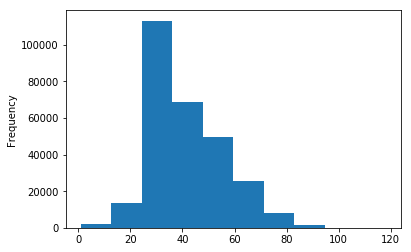

In [8]:
age = df.age.copy()
age[age > 120] = None
age.plot('hist');

## Test analysis

In [9]:
tdf = initial_pre(pd.read_csv(TEST_PATH))
tdf.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup
0,Z39.2,Рутинное послеродовое наблюдение,41,2,Общее самочувствие удовлетворительное. Кожные ...,Аллергию на лекарства - отрицает.,NaN,NaN
1,M54.2,Цервикалгия,64,2,NaN,не отягощен,NaN,NaN
2,M41,Сколиоз,34,2,"Удовлетворительное. Температура тела - 36,6. С...",NaN,NaN,NaN
3,J31.2,Хронический фарингит,58,2,NaN,NaN,NaN,Общее состояние удовлетворительное. Конфигурац...
4,M21.4,Плоская стопа [pes planus] (приобретенная),34,2,NaN,NaN,Жалобы сегодня с утра,NaN


In [10]:
df.sex.value_counts()

2    200523
1     82563
Name: sex, dtype: int64

In [11]:
tdf.sex.value_counts()

2    66391
1    33609
Name: sex, dtype: int64

## Preprocess

### Only `anamnesis`

In [12]:
# def make_textclf_data(df, balance=False):
#     X, y = df.anamnesis.fillna(''), df.revisit
    
#     if balance:
#         n = y.value_counts().min()
#         y0, y1 = y[y == 0].sample(n), y[y == 1].sample(n)
#         X0, X1 = X[y0.index], X[y1.index]
#         X, y = pd.concat([X0, X1], axis=0).sample(frac=1), pd.concat([y0, y1], axis=0).sample(frac=1)
    
#     return X, y

### Features

In [13]:
def parse_diag_code(diag_code, 
                    dc_pattern=re.compile('([A-Z])?([0-9][0-9])?(\.([0-9]))?')):
    m = dc_pattern.match(diag_code)
    letter, code, subcode = m.group(1), m.group(2), m.group(4)
    code = int(code) if code is not None else None
    subcode = int(subcode) if subcode is not None else None
    return letter, code, subcode


# def get_age_group(age):
#     if age > 120:
#         return None
# #     df.age.as_matrix()[:, np.newaxis].shape
#     return 0

In [14]:
class FFTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sex_1d=None):
        self.sex_1d = sex_1d
    
    def fit(self, df):
        return self
    
    def transform(self, df):
        df = df.copy()
        
        if self.sex_1d:
            n = int((df.sex == 1).sum() / self.sex_1d)
            df1 = df[df.sex == 1]
            df2 = df[df.sex == 2].sample(n)
            df = pd.concat([df1, df2], axis=0)
    
        features = []
        # diag_code
        features.append(pd.DataFrame(list(df.diag_code.apply(parse_diag_code)), 
                                     columns=['letter', 'code', 'subcode'],
                                     dtype=object, index=df.index))
        
        # diag
        features.append(df[['diag']])

        # age
        df.age = df.age.astype(float)
        df.loc[df.age > 120, 'age'] = np.nan
        features.append(df[['age']])

        # sex
        features.append(df[['sex']])

        # state, allergies, checkup, -anamnesis
        features.append(df[['state', 'allergies', 'checkup']])

        data = pd.concat(features, axis=1)
        data = data.apply(lambda c: c.fillna('NaN') if (c.dtype == object) else c)
        if 'revisit' in df:
            data = (data, df.revisit)

        return data

In [15]:
ff = FFTransformer()
X, y = ff.fit_transform(df)
X.head()

,letter,code,subcode,diag,age,sex,state,allergies,checkup
0,J,6,0,Острый ларингофарингит,29.0,2,NaN,NaN,На жевательной поверхности 2.6- кариозная поло...
1,N,76,1,Подострый и хронический вагинит,45.0,2,NaN,NaN,NaN
2,L,23,9,"Аллергический контактный дерматит, причина не ...",63.0,2,NaN,NaN,NaN
3,N,48,1,Баланопостит,43.0,2,NaN,не отягощен,NaN
4,Z,0,0,Общий медицинский осмотр,29.0,1,NaN,NaN,NaN


In [16]:
X.dtypes

letter        object
code           int64
subcode       object
diag          object
age          float64
sex            int64
state         object
allergies     object
checkup       object
dtype: object

In [17]:
y.dtype

dtype('int64')

## TT split

In [18]:
preprocess = FFTransformer()
X, y = preprocess.fit_transform(df)
cat_features = np.where(X.dtypes != np.float)[0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
X_test = preprocess.transform(tdf)
X_train.shape, X_val.shape, X_test.shape

((254777, 9), (28309, 9), (100000, 9))

## Scipy

In [19]:
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import SGDClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [20]:
# model = Pipeline([
#     ('vec', TfidfVectorizer(ngram_range=(1, 3), max_features=1000)),
#     ('clf', MLPClassifier(hidden_layer_sizes=(300, 300, 2))),
#  ])

In [21]:
# %time model.fit(X_train, y_train)

In [22]:
# y_pred = model.predict(X_test)
# (y_pred == y_test).sum() / len(y_test)

In [23]:
# roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

## Keras

https://gist.github.com/madrugado/63c068b52a135c6fdbbb6fe17acbc0c8

In [24]:
# from keras.preprocessing.text import Tokenizer

In [25]:
# tokenizer = Tokenizer(num_words=1000)
# tokenizer.fit_on_texts(X_train)

In [26]:
# X_train = tokenizer.texts_to_matrix(X_train, mode='binary')
# X_test = tokenizer.texts_to_matrix(X_test, mode='binary')
# X_train.shape, X_test.shape

## CatBoost

https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning-docpage/

In [27]:
import catboost as cb

In [28]:
model = cb.CatBoostClassifier(depth=8, eval_metric='AUC')
model.fit(X_train, y_train, cat_features=cat_features, 
          use_best_model=True, eval_set=(X_val, y_val), 
          plot=False);

0:	learn: 0.6518951	test: 0.6501391	best: 0.6501391 (0)	total: 338ms	remaining: 5m 38s
1:	learn: 0.6540380	test: 0.6517113	best: 0.6517113 (1)	total: 633ms	remaining: 5m 15s
2:	learn: 0.6541380	test: 0.6519298	best: 0.6519298 (2)	total: 865ms	remaining: 4m 47s
3:	learn: 0.6550646	test: 0.6527750	best: 0.6527750 (3)	total: 1.13s	remaining: 4m 42s
4:	learn: 0.6551844	test: 0.6527911	best: 0.6527911 (4)	total: 1.37s	remaining: 4m 33s
5:	learn: 0.6561195	test: 0.6536093	best: 0.6536093 (5)	total: 1.65s	remaining: 4m 33s
6:	learn: 0.6564016	test: 0.6537745	best: 0.6537745 (6)	total: 1.93s	remaining: 4m 34s
7:	learn: 0.6579523	test: 0.6548329	best: 0.6548329 (7)	total: 2.21s	remaining: 4m 34s
8:	learn: 0.6587463	test: 0.6556212	best: 0.6556212 (8)	total: 2.47s	remaining: 4m 31s
9:	learn: 0.6593741	test: 0.6561998	best: 0.6561998 (9)	total: 2.75s	remaining: 4m 31s
10:	learn: 0.6595818	test: 0.6562952	best: 0.6562952 (10)	total: 3.01s	remaining: 4m 30s
11:	learn: 0.6599057	test: 0.6565807	best

93:	learn: 0.7197162	test: 0.7151122	best: 0.7151122 (93)	total: 25.1s	remaining: 4m 2s
94:	learn: 0.7198893	test: 0.7152259	best: 0.7152259 (94)	total: 25.4s	remaining: 4m 1s
95:	learn: 0.7199652	test: 0.7152865	best: 0.7152865 (95)	total: 25.7s	remaining: 4m 1s
96:	learn: 0.7200974	test: 0.7153740	best: 0.7153740 (96)	total: 26s	remaining: 4m 1s
97:	learn: 0.7202978	test: 0.7155136	best: 0.7155136 (97)	total: 26.2s	remaining: 4m 1s
98:	learn: 0.7204471	test: 0.7156294	best: 0.7156294 (98)	total: 26.5s	remaining: 4m 1s
99:	learn: 0.7205505	test: 0.7156800	best: 0.7156800 (99)	total: 26.9s	remaining: 4m 1s
100:	learn: 0.7206724	test: 0.7157188	best: 0.7157188 (100)	total: 27.2s	remaining: 4m 1s
101:	learn: 0.7207359	test: 0.7157626	best: 0.7157626 (101)	total: 27.5s	remaining: 4m 1s
102:	learn: 0.7209027	test: 0.7158582	best: 0.7158582 (102)	total: 27.7s	remaining: 4m 1s
103:	learn: 0.7209838	test: 0.7159197	best: 0.7159197 (103)	total: 28.1s	remaining: 4m 2s
104:	learn: 0.7210874	test

185:	learn: 0.7259849	test: 0.7193472	best: 0.7193472 (185)	total: 54.6s	remaining: 3m 58s
186:	learn: 0.7260311	test: 0.7193502	best: 0.7193502 (186)	total: 55s	remaining: 3m 58s
187:	learn: 0.7260600	test: 0.7193555	best: 0.7193555 (187)	total: 55.3s	remaining: 3m 58s
188:	learn: 0.7260998	test: 0.7193611	best: 0.7193611 (188)	total: 55.7s	remaining: 3m 58s
189:	learn: 0.7261316	test: 0.7193778	best: 0.7193778 (189)	total: 56s	remaining: 3m 58s
190:	learn: 0.7261495	test: 0.7193725	best: 0.7193778 (189)	total: 56.3s	remaining: 3m 58s
191:	learn: 0.7261805	test: 0.7193836	best: 0.7193836 (191)	total: 56.7s	remaining: 3m 58s
192:	learn: 0.7262322	test: 0.7194286	best: 0.7194286 (192)	total: 57s	remaining: 3m 58s
193:	learn: 0.7262705	test: 0.7194475	best: 0.7194475 (193)	total: 57.3s	remaining: 3m 58s
194:	learn: 0.7263110	test: 0.7194652	best: 0.7194652 (194)	total: 57.7s	remaining: 3m 58s
195:	learn: 0.7263476	test: 0.7194784	best: 0.7194784 (195)	total: 58s	remaining: 3m 57s
196:	le

275:	learn: 0.7290671	test: 0.7201656	best: 0.7201712 (273)	total: 1m 25s	remaining: 3m 44s
276:	learn: 0.7290925	test: 0.7201764	best: 0.7201764 (276)	total: 1m 25s	remaining: 3m 44s
277:	learn: 0.7291268	test: 0.7201997	best: 0.7201997 (277)	total: 1m 26s	remaining: 3m 44s
278:	learn: 0.7291655	test: 0.7202177	best: 0.7202177 (278)	total: 1m 26s	remaining: 3m 44s
279:	learn: 0.7291882	test: 0.7202260	best: 0.7202260 (279)	total: 1m 27s	remaining: 3m 43s
280:	learn: 0.7292479	test: 0.7202416	best: 0.7202416 (280)	total: 1m 27s	remaining: 3m 43s
281:	learn: 0.7293127	test: 0.7202480	best: 0.7202480 (281)	total: 1m 27s	remaining: 3m 43s
282:	learn: 0.7293485	test: 0.7202465	best: 0.7202480 (281)	total: 1m 28s	remaining: 3m 43s
283:	learn: 0.7293754	test: 0.7202465	best: 0.7202480 (281)	total: 1m 28s	remaining: 3m 43s
284:	learn: 0.7294004	test: 0.7202530	best: 0.7202530 (284)	total: 1m 28s	remaining: 3m 42s
285:	learn: 0.7294388	test: 0.7202625	best: 0.7202625 (285)	total: 1m 29s	remain

365:	learn: 0.7320391	test: 0.7206750	best: 0.7206815 (344)	total: 1m 57s	remaining: 3m 24s
366:	learn: 0.7320699	test: 0.7206783	best: 0.7206815 (344)	total: 1m 58s	remaining: 3m 23s
367:	learn: 0.7320976	test: 0.7206811	best: 0.7206815 (344)	total: 1m 58s	remaining: 3m 23s
368:	learn: 0.7321351	test: 0.7206949	best: 0.7206949 (368)	total: 1m 58s	remaining: 3m 23s
369:	learn: 0.7321531	test: 0.7206995	best: 0.7206995 (369)	total: 1m 59s	remaining: 3m 23s
370:	learn: 0.7321956	test: 0.7206944	best: 0.7206995 (369)	total: 1m 59s	remaining: 3m 22s
371:	learn: 0.7322121	test: 0.7206853	best: 0.7206995 (369)	total: 2m	remaining: 3m 22s
372:	learn: 0.7322218	test: 0.7206845	best: 0.7206995 (369)	total: 2m	remaining: 3m 22s
373:	learn: 0.7322430	test: 0.7206983	best: 0.7206995 (369)	total: 2m	remaining: 3m 22s
374:	learn: 0.7322773	test: 0.7206927	best: 0.7206995 (369)	total: 2m 1s	remaining: 3m 21s
375:	learn: 0.7323005	test: 0.7206875	best: 0.7206995 (369)	total: 2m 1s	remaining: 3m 21s
37

455:	learn: 0.7343885	test: 0.7209224	best: 0.7209301 (450)	total: 2m 29s	remaining: 2m 57s
456:	learn: 0.7344152	test: 0.7209387	best: 0.7209387 (456)	total: 2m 29s	remaining: 2m 57s
457:	learn: 0.7344649	test: 0.7209676	best: 0.7209676 (457)	total: 2m 29s	remaining: 2m 57s
458:	learn: 0.7344805	test: 0.7209700	best: 0.7209700 (458)	total: 2m 30s	remaining: 2m 56s
459:	learn: 0.7345163	test: 0.7209752	best: 0.7209752 (459)	total: 2m 30s	remaining: 2m 56s
460:	learn: 0.7345200	test: 0.7209618	best: 0.7209752 (459)	total: 2m 30s	remaining: 2m 56s
461:	learn: 0.7345388	test: 0.7209615	best: 0.7209752 (459)	total: 2m 31s	remaining: 2m 55s
462:	learn: 0.7345662	test: 0.7209825	best: 0.7209825 (462)	total: 2m 31s	remaining: 2m 55s
463:	learn: 0.7345877	test: 0.7209774	best: 0.7209825 (462)	total: 2m 31s	remaining: 2m 55s
464:	learn: 0.7346218	test: 0.7209762	best: 0.7209825 (462)	total: 2m 32s	remaining: 2m 55s
465:	learn: 0.7346292	test: 0.7209765	best: 0.7209825 (462)	total: 2m 32s	remain

545:	learn: 0.7364882	test: 0.7211205	best: 0.7211205 (545)	total: 3m	remaining: 2m 29s
546:	learn: 0.7364968	test: 0.7211152	best: 0.7211205 (545)	total: 3m	remaining: 2m 29s
547:	learn: 0.7365105	test: 0.7211188	best: 0.7211205 (545)	total: 3m 1s	remaining: 2m 29s
548:	learn: 0.7365382	test: 0.7211267	best: 0.7211267 (548)	total: 3m 1s	remaining: 2m 28s
549:	learn: 0.7365533	test: 0.7211254	best: 0.7211267 (548)	total: 3m 1s	remaining: 2m 28s
550:	learn: 0.7365643	test: 0.7211248	best: 0.7211267 (548)	total: 3m 1s	remaining: 2m 28s
551:	learn: 0.7365782	test: 0.7211157	best: 0.7211267 (548)	total: 3m 2s	remaining: 2m 27s
552:	learn: 0.7365964	test: 0.7211302	best: 0.7211302 (552)	total: 3m 2s	remaining: 2m 27s
553:	learn: 0.7366144	test: 0.7211273	best: 0.7211302 (552)	total: 3m 2s	remaining: 2m 27s
554:	learn: 0.7366431	test: 0.7211314	best: 0.7211314 (554)	total: 3m 3s	remaining: 2m 26s
555:	learn: 0.7366944	test: 0.7211634	best: 0.7211634 (555)	total: 3m 3s	remaining: 2m 26s
556:	

635:	learn: 0.7385293	test: 0.7211994	best: 0.7212132 (581)	total: 3m 31s	remaining: 2m 1s
636:	learn: 0.7385441	test: 0.7212016	best: 0.7212132 (581)	total: 3m 31s	remaining: 2m
637:	learn: 0.7385898	test: 0.7212239	best: 0.7212239 (637)	total: 3m 32s	remaining: 2m
638:	learn: 0.7386084	test: 0.7212291	best: 0.7212291 (638)	total: 3m 32s	remaining: 2m
639:	learn: 0.7386217	test: 0.7212339	best: 0.7212339 (639)	total: 3m 32s	remaining: 1m 59s
640:	learn: 0.7386522	test: 0.7212250	best: 0.7212339 (639)	total: 3m 33s	remaining: 1m 59s
641:	learn: 0.7386658	test: 0.7212291	best: 0.7212339 (639)	total: 3m 33s	remaining: 1m 59s
642:	learn: 0.7387017	test: 0.7212246	best: 0.7212339 (639)	total: 3m 33s	remaining: 1m 58s
643:	learn: 0.7387247	test: 0.7212136	best: 0.7212339 (639)	total: 3m 34s	remaining: 1m 58s
644:	learn: 0.7387486	test: 0.7212152	best: 0.7212339 (639)	total: 3m 34s	remaining: 1m 58s
645:	learn: 0.7387701	test: 0.7212246	best: 0.7212339 (639)	total: 3m 35s	remaining: 1m 57s
6

725:	learn: 0.7404857	test: 0.7213320	best: 0.7213583 (721)	total: 4m 2s	remaining: 1m 31s
726:	learn: 0.7405094	test: 0.7213348	best: 0.7213583 (721)	total: 4m 3s	remaining: 1m 31s
727:	learn: 0.7405569	test: 0.7213222	best: 0.7213583 (721)	total: 4m 3s	remaining: 1m 31s
728:	learn: 0.7405746	test: 0.7213269	best: 0.7213583 (721)	total: 4m 3s	remaining: 1m 30s
729:	learn: 0.7405874	test: 0.7213310	best: 0.7213583 (721)	total: 4m 4s	remaining: 1m 30s
730:	learn: 0.7406220	test: 0.7213353	best: 0.7213583 (721)	total: 4m 4s	remaining: 1m 30s
731:	learn: 0.7406522	test: 0.7213295	best: 0.7213583 (721)	total: 4m 4s	remaining: 1m 29s
732:	learn: 0.7406658	test: 0.7213125	best: 0.7213583 (721)	total: 4m 5s	remaining: 1m 29s
733:	learn: 0.7406809	test: 0.7213055	best: 0.7213583 (721)	total: 4m 5s	remaining: 1m 29s
734:	learn: 0.7407028	test: 0.7213022	best: 0.7213583 (721)	total: 4m 6s	remaining: 1m 28s
735:	learn: 0.7407133	test: 0.7212977	best: 0.7213583 (721)	total: 4m 6s	remaining: 1m 28s

815:	learn: 0.7425680	test: 0.7214351	best: 0.7214512 (776)	total: 4m 34s	remaining: 1m 1s
816:	learn: 0.7425970	test: 0.7214336	best: 0.7214512 (776)	total: 4m 34s	remaining: 1m 1s
817:	learn: 0.7426252	test: 0.7214342	best: 0.7214512 (776)	total: 4m 34s	remaining: 1m 1s
818:	learn: 0.7426525	test: 0.7214471	best: 0.7214512 (776)	total: 4m 35s	remaining: 1m
819:	learn: 0.7426692	test: 0.7214546	best: 0.7214546 (819)	total: 4m 35s	remaining: 1m
820:	learn: 0.7426822	test: 0.7214569	best: 0.7214569 (820)	total: 4m 36s	remaining: 1m
821:	learn: 0.7426979	test: 0.7214525	best: 0.7214569 (820)	total: 4m 36s	remaining: 59.9s
822:	learn: 0.7427320	test: 0.7214573	best: 0.7214573 (822)	total: 4m 36s	remaining: 59.5s
823:	learn: 0.7427694	test: 0.7214651	best: 0.7214651 (823)	total: 4m 37s	remaining: 59.2s
824:	learn: 0.7427948	test: 0.7214796	best: 0.7214796 (824)	total: 4m 37s	remaining: 58.9s
825:	learn: 0.7428003	test: 0.7214814	best: 0.7214814 (825)	total: 4m 37s	remaining: 58.5s
826:	lea

906:	learn: 0.7445845	test: 0.7215866	best: 0.7215866 (906)	total: 5m 6s	remaining: 31.4s
907:	learn: 0.7445935	test: 0.7215889	best: 0.7215889 (907)	total: 5m 6s	remaining: 31s
908:	learn: 0.7446048	test: 0.7215812	best: 0.7215889 (907)	total: 5m 6s	remaining: 30.7s
909:	learn: 0.7446368	test: 0.7215844	best: 0.7215889 (907)	total: 5m 7s	remaining: 30.4s
910:	learn: 0.7446533	test: 0.7215823	best: 0.7215889 (907)	total: 5m 7s	remaining: 30s
911:	learn: 0.7446756	test: 0.7215756	best: 0.7215889 (907)	total: 5m 7s	remaining: 29.7s
912:	learn: 0.7446897	test: 0.7215812	best: 0.7215889 (907)	total: 5m 8s	remaining: 29.4s
913:	learn: 0.7446990	test: 0.7215820	best: 0.7215889 (907)	total: 5m 8s	remaining: 29s
914:	learn: 0.7447210	test: 0.7215809	best: 0.7215889 (907)	total: 5m 8s	remaining: 28.7s
915:	learn: 0.7447527	test: 0.7215827	best: 0.7215889 (907)	total: 5m 9s	remaining: 28.4s
916:	learn: 0.7447754	test: 0.7215805	best: 0.7215889 (907)	total: 5m 9s	remaining: 28s
917:	learn: 0.7448

997:	learn: 0.7463191	test: 0.7217121	best: 0.7217349 (984)	total: 5m 38s	remaining: 679ms
998:	learn: 0.7463484	test: 0.7217092	best: 0.7217349 (984)	total: 5m 39s	remaining: 340ms
999:	learn: 0.7463843	test: 0.7217076	best: 0.7217349 (984)	total: 5m 39s	remaining: 0us

bestTest = 0.7217348767
bestIteration = 984

Shrink model to first 985 iterations.


In [29]:
model.is_fitted_

True

## Analysis

In [30]:
roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

0.7217348766673947

In [31]:
model.get_params()

{'depth': 8, 'eval_metric': 'AUC', 'loss_function': 'Logloss'}

In [32]:
def draw_importance(columns, importances, top_k=20, save_path=None):
    order = np.argsort(importances)[-top_k:]
    
    objects = columns[order]
    y_pos = np.arange(len(objects))
    performance = np.array(importances)[order]

    plt.figure(figsize=(20, 10))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Importance')
    plt.title('Feature')

    if save_path:
        plt.savefig(save_path)
    plt.show()

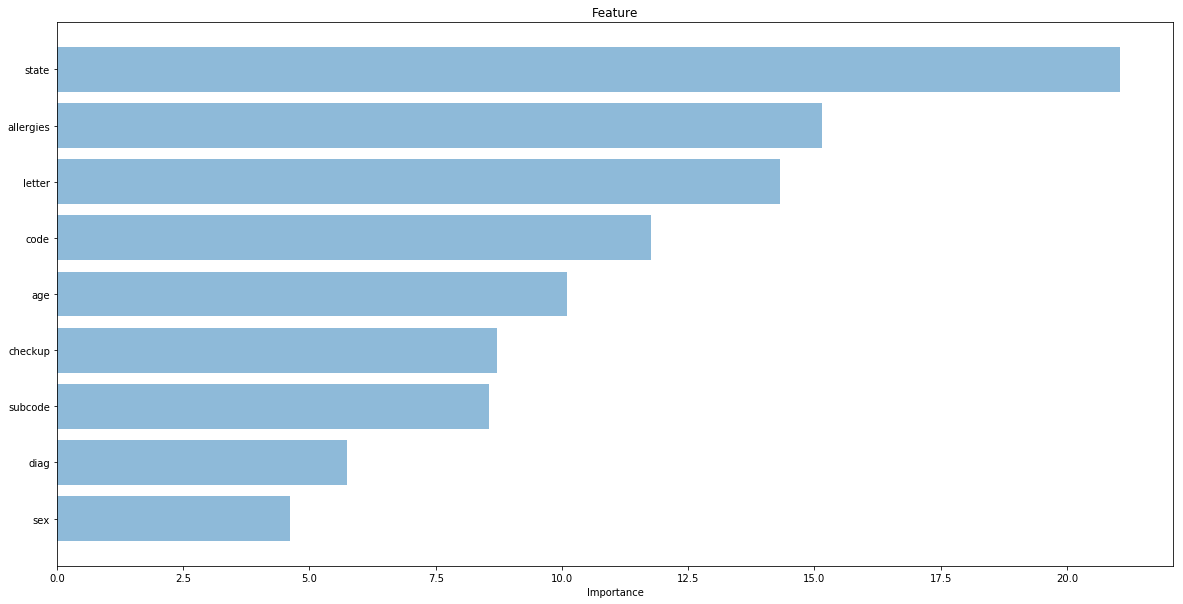

In [33]:
draw_importance(X_train.columns, model.feature_importances_, save_path=None)

## Submission

In [34]:
sdf = pd.DataFrame(tdf.index, columns=['ID'])
sdf['proba'] = model.predict_proba(X_test)[:, 1]
sdf.head()

,ID,proba
0,0,0.869019
1,1,0.881202
2,2,0.664073
3,3,0.960042
4,4,0.661674


In [35]:
sdf.to_csv(SUBMISSION_PATH, index=False)